In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
x, y = np.meshgrid(np.linspace(-2,2,20), np.linspace(-2,2,20))
d = np.sqrt(x*x+y*y)
sigma, mu = 0.5, 0.0
a = 200.0 / (sigma * np.sqrt(2.0 * np.pi))
g = a * np.exp(-((d - mu)**2 / (2.0 * sigma**2)))
g = g.astype(np.int64)
print(g.dtype)
print(g.shape)

int64
(20, 20)


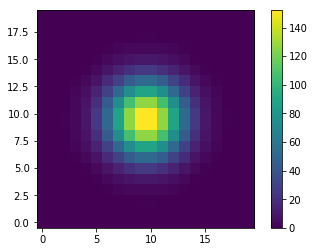

In [3]:
plt.figure()
plt.imshow(g, origin='lower')
plt.colorbar()

In [4]:
np.random.seed(1000)
ccd_shape = (480, 640)

In [5]:
percentage = 0.2
x_range = percentage * ccd_shape[1]
y_range = percentage * ccd_shape[0]
# Pick lower left corner for insertion
x_halfwidth = ccd_shape[1] / 2
y_halfwidth = ccd_shape[0] / 2
xpoint = np.random.randint(x_halfwidth - x_range, x_halfwidth + x_range + 1)
ypoint = np.random.randint(y_halfwidth - y_range, y_halfwidth + y_range + 1)
print(xpoint, ypoint)

279 215


In [6]:
ccd = np.random.poisson(20.0, ccd_shape)

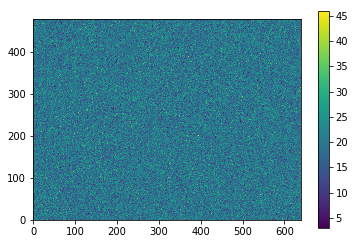

In [7]:
plt.imshow(ccd, origin='lower')
plt.colorbar()

(array([3.0000e+00, 1.5000e+01, 5.1000e+01, 1.5600e+02, 4.1700e+02,
        8.4900e+02, 1.7650e+03, 3.2470e+03, 5.3660e+03, 8.3350e+03,
        1.1987e+04, 1.6041e+04, 1.9630e+04, 4.9207e+04, 2.7304e+04,
        2.7458e+04, 2.5734e+04, 2.3630e+04, 2.0463e+04, 1.7022e+04,
        1.3791e+04, 1.0591e+04, 7.9730e+03, 5.5450e+03, 3.9150e+03,
        2.5100e+03, 2.7610e+03, 5.9900e+02, 3.8500e+02, 2.0600e+02,
        1.1800e+02, 6.0000e+01, 3.3000e+01, 1.9000e+01, 7.0000e+00,
        4.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ 3.   ,  4.075,  5.15 ,  6.225,  7.3  ,  8.375,  9.45 , 10.525,
        11.6  , 12.675, 13.75 , 14.825, 15.9  , 16.975, 18.05 , 19.125,
        20.2  , 21.275, 22.35 , 23.425, 24.5  , 25.575, 26.65 , 27.725,
        28.8  , 29.875, 30.95 , 32.025, 33.1  , 34.175, 35.25 , 36.325,
        37.4  , 38.475, 39.55 , 40.625, 41.7  , 42.775, 43.85 , 44.925,
        46.   ]),
 <a list of 40 Patch objects>)

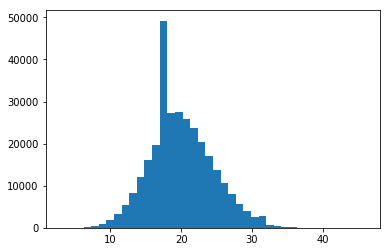

In [8]:
plt.hist(ccd.flatten(), bins=40)

In [9]:
ccd[ypoint:ypoint+g.shape[0], xpoint:xpoint+g.shape[1]] += g

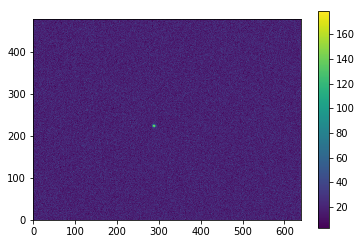

In [10]:
plt.imshow(ccd, origin='lower')
plt.colorbar()

In [11]:
np.where(ccd==np.max(ccd))

(array([225]), array([288]))

In [12]:
ccd.shape

(480, 640)

# Full Frame Processing

In [13]:
from scipy import ndimage

In [14]:
img_std = ndimage.standard_deviation(ccd)

In [15]:
threshold = np.median(ccd) + 5.0 * img_std

In [16]:
print(threshold, img_std)

43.162967406380616 4.632593481276123


In [17]:
mask = ccd > threshold

In [18]:
labels_im, nb_labels = ndimage.label(mask)

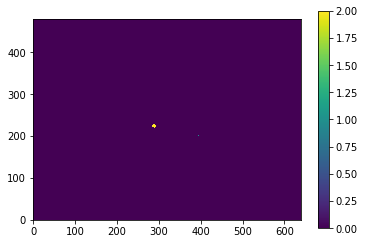

In [19]:
plt.imshow(labels_im, origin='lower')
plt.colorbar()

In [20]:
nb_labels

2

In [21]:
sizes = ndimage.sum(mask, labels_im, range(nb_labels + 1))

In [22]:
sizes

array([ 0.,  1., 68.])

In [23]:
# The 10 is a number of pixels to be required in the feature
mask_size = sizes < 10
remove_pixel = mask_size[labels_im]

In [24]:
mask_size

array([ True,  True, False])

In [25]:
labels_im[remove_pixel] = 0

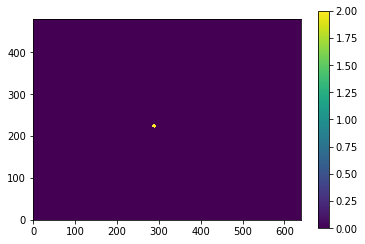

In [26]:
plt.imshow(labels_im, origin='lower')
plt.colorbar()

In [27]:
labels = np.unique(labels_im)

In [28]:
labels_im = np.searchsorted(labels, labels_im)

In [29]:
objects = ndimage.find_objects(labels_im)

In [30]:
objects

[(slice(220, 230, None), slice(284, 294, None))]

In [31]:
size_obj = ndimage.sum(mask, labels_im, 1)
print(size_obj)

68


In [32]:
# Original code has third parameter, but there doesn't seem to be one here
y_slice, x_slice = objects[0]

In [33]:
spot_img = ccd[y_slice, x_slice] - threshold
spot_img[spot_img < 0] = 0

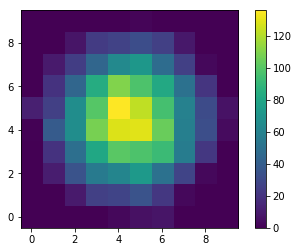

In [34]:
plt.imshow(spot_img, origin='lower')
plt.colorbar()

In [35]:
flux = spot_img.sum()
count_max = spot_img.max()

In [36]:
print(flux, count_max)

3235.9182163661176 135.83703259361937


In [37]:
com_x, com_y = ndimage.center_of_mass(spot_img)

In [38]:
center_x = com_x + x_slice.start
center_y = com_y + y_slice.start

In [39]:
print(center_x, center_y)

288.45394404821826 224.47687644439395


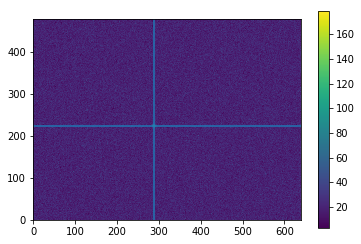

In [40]:
plt.imshow(ccd, origin='lower')
plt.axhline(center_y)
plt.axvline(center_x)
plt.colorbar()

In [41]:
pixel_center_x = int(center_x)
pixel_center_y = int(center_y)
print(pixel_center_x, pixel_center_y)

288 224


# ROI Frame Processing

In [42]:
# Create ROI frame
boxsize = 50
